In the interest of flexibility and performance, I need to make some breaking changes to my code. First, the code should be able to handle networks with multiple conductor types. The new `solve_temporal_instanton` requires a `line_conductors` input, which is a vector of strings indicating the conductor type of each line in the network.

Preparing this input means translating voltage information into conductor information. Here's a function that does that:

In [2]:
# Analysis:
#addprocs(4)
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

In [3]:
Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

  Please email questions, comments, and significant results to: Robert.C.Green@gmail.com.  Thanks!


In [4]:
# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

# time_values = 0:60:600 # ten minutes in 1-min steps
# int_length = 600. # seconds
# G0 = [0.7*Gp;0.7*Gp;0.7*Gp]
# D0 = [0.9*Dp;0.9*Dp;0.9*Dp]
# P0 = [Rp;1.5*Rp;1.5*Rp]

time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

438-element Array{Float64,1}:
 0.0      
 0.0820657
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      

In [11]:
# no. of steps calculated using G0.
# int_length calculated
@time score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

elapsed time: 13.043654154 seconds (5274097432 bytes allocated, 37.43% gc time)


In [12]:
# Plotting:
using Interact
using PyPlot
PyPlot.svg(true)

INFO: Loading help data...


true

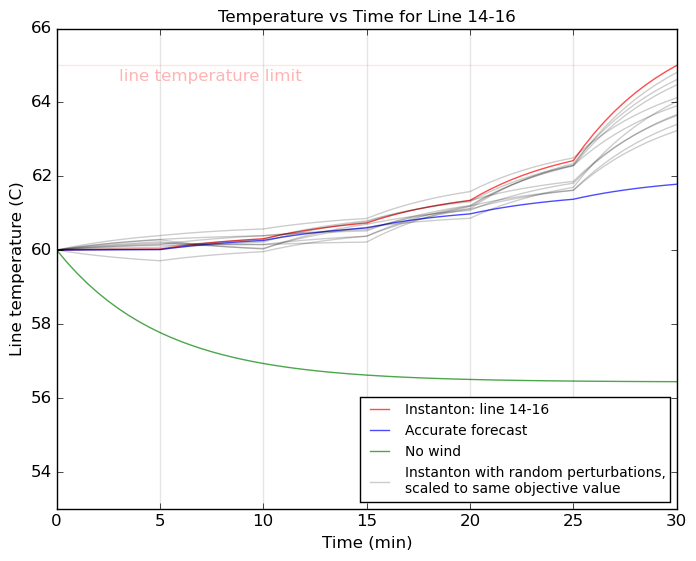

PyObject <matplotlib.text.Text object at 0x7f8187d959d0>

In [16]:
# Choose event index (1 is instanton):
eidx = 1

# System parameters:
n = length(k)
nr = length(Ridx)
num_intervals = convert(Int64,length(find(P0))/nr)

# Thermal parameters:
conductor_name = "waxwing"
cp = return_conductor_params(conductor_name)
Tlim = cp.Tlim
ηc = cp.ηc
ηr = cp.ηr
qs = cp.qs
mCp = cp.mCp
Tmid = (Tamb + Tlim)/2
temp_eq(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3) # Fixed wrt power flow

# Line parameters:
idx = find(score.==sort(score)[eidx])[1]
line = lines[line_lengths.!=0][idx]
from,to = line
r_ij = res[line_lengths.!=0][idx]
x_ij = reac[line_lengths.!=0][idx]
L_ij = line_lengths[line_lengths.!=0][idx]

# Generate this many random vectors:
numVecs = 10
vecs = Array(Vector,0)

# First vector is instanton analysis output:
tempVec = Array(FloatingPoint,0)
for i in 1:num_intervals
    append!(tempVec,x[idx][i])
end
push!(vecs,tempVec)

# Second vector represents accurate forecast:
push!(vecs,zeros(length(vecs[1])))

# Third vector cancels all wind gen:
push!(vecs,-P0[find(P0)])

# Add a family of vectors with same norm as
# instanton vector:
for i = 1:numVecs
    # Uniform RVs in [-1/2, 1/2)
    inter = vecs[1] + (rand(nr*num_intervals) - 0.5).*(i+1)/35
    # Normalize to match min-score objective:
    traj = sqrt(score[idx])*inter/norm(inter)
    push!(vecs,traj)
end

# Use power flow data and thermal model to compute
# temperature trajectories for each vector:
temp_trajectories = Array(Vector,0)
angle_dump = Array(Vector,0)
diffs_dump = Array(Vector,0)
for i in 1:size(vecs,1)
    fixed_wind = vecs[i]
    fixed_A = fixed_wind_A(num_intervals,Y,ref,k)
    fixed_P = expand_renewable_vector(fixed_wind,Ridx,n,num_intervals)
    fixed_b = fixed_wind_b(n,T,G0,P0+fixed_P,D0)
    fixed_x = fixed_A\fixed_b
    angles,alpha = return_angles(fixed_x,n,num_intervals)
    push!(angle_dump,angles)
    fixed_diffs = return_angle_diffs(angles,line)
    push!(diffs_dump,fixed_diffs)

    T0 = 60. #46.
    temp_values = [T0]
    power_flow = Float64[]

    for θij in fixed_diffs
        f_loss_pu = r_ij*(θij/x_ij)^2 # pu
        f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
        push!(power_flow,(Sb/1e6)*θij/x_ij)
        therm_b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
                temp_values = [temp_values,temp_eq(time_values,T0,therm_a,therm_b)[2:end]]
        T0 = temp_values[end]
    end
    push!(temp_trajectories,temp_values)
end

# Plot
fig = figure(figsize=(8,6))
xvals = (0:length(temp_trajectories[1])-1)*num_intervals*int_length/(60*(length(temp_trajectories[1])-1))
for i in 1:size(temp_trajectories,1)
    if i == 1
        plot(xvals,temp_trajectories[i],alpha=0.7,"r")
        elseif i == 2
        plot(xvals,temp_trajectories[i],alpha=0.7,"b")
        elseif i == 3
        plot(xvals,temp_trajectories[i],alpha=0.7,"g")
    else
        plot(xvals,temp_trajectories[i],alpha=0.2,"k")
    end
end
title("Temperature vs Time for Line $(from)-$(to)",fontsize=12)
xlabel("Time (min)")
ylabel("Line temperature (C)")
legend(["Instanton: line $(from)-$(to)",
    "Accurate forecast",    
    "No wind",
    "Instanton with random perturbations, \nscaled to same objective value"],fontsize=10,loc=4)
axis([0,30,53,66])
for i in 1:num_intervals
    xval = i*int_length/60
    plot([xval;xval],[40,1.1*Tlim],"k",alpha=0.1)
end
plot([0,30],[Tlim;Tlim],"r",alpha=0.1)
text(3,64.6,"line temperature limit",color="red",alpha=0.3)#color="#FFB2B2")

#savefig("../images/2015-06-24-trajectory_compare3.png", dpi=600)

## Problem

When I use only waxwing, everything works as it has for a while now. But when I use a mix of waxwing and dove, the results are nonsense. All the scores are higher! The same line with the same conductor parameters should not get a higher instanton score just because other lines have different parameters.

I need to debug this...